In [83]:
# to working with graphs
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# to working with financial data
import yfinance as yf

# for building model
from prophet import Prophet

# for data analysis
from pandas.plotting import autocorrelation_plot
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import shapiro, boxcox
from sklearn.preprocessing import StandardScaler

# for statical analysis of time series data
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.tsa.api as smt
from statsmodels.stats.diagnostic import kstest_normal
from statsmodels.tsa.seasonal import seasonal_decompose

# for auto arima model
import pmdarima as pm

# graph settings
import warnings
import hvplot.pandas
import hvplot as hv

# warnings
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")


In [21]:
df = pd.read_csv('data/data.csv')

In [22]:
df['dt'] = pd.to_datetime(df['dt'])
df.columns = ['ds','y']

# EDA

In [41]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    """
    Generates a time series plot along with autocorrelation and partial autocorrelation plots.

    Parameters:
    - y (pd.Series or array-like): Time series data to be plotted.
    - lags (int or None, optional): Number of lags to include in autocorrelation plots. Defaults to None.
    - figsize (tuple, optional): Size of the entire figure. Defaults to (14, 8).
    - style (str, optional): Matplotlib style to apply to the plots. Defaults to 'bmh'.

    Example Usage:
    
    # Assuming 'my_timeseries' is a Pandas Series
    tsplot(my_timeseries, lags=40)
    """

    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()

In [42]:
def is_normal(test, p_level=0.05):
    """
    Checks the normality of a statistical test based on its p-value.

    Parameters:
    - test (tuple): Tuple containing the test statistic and p-value.
    - p_level (float, optional): Significance level for the normality test. Defaults to 0.05.
    Returns
    - result (str): String indicating whether the data is considered normal or not based on the p-value.
    Example Usage:

    # Assuming 'shapiro_test' is a tuple with the test statistic and p-value
    result = is_normal(shapiro_test)
    """
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

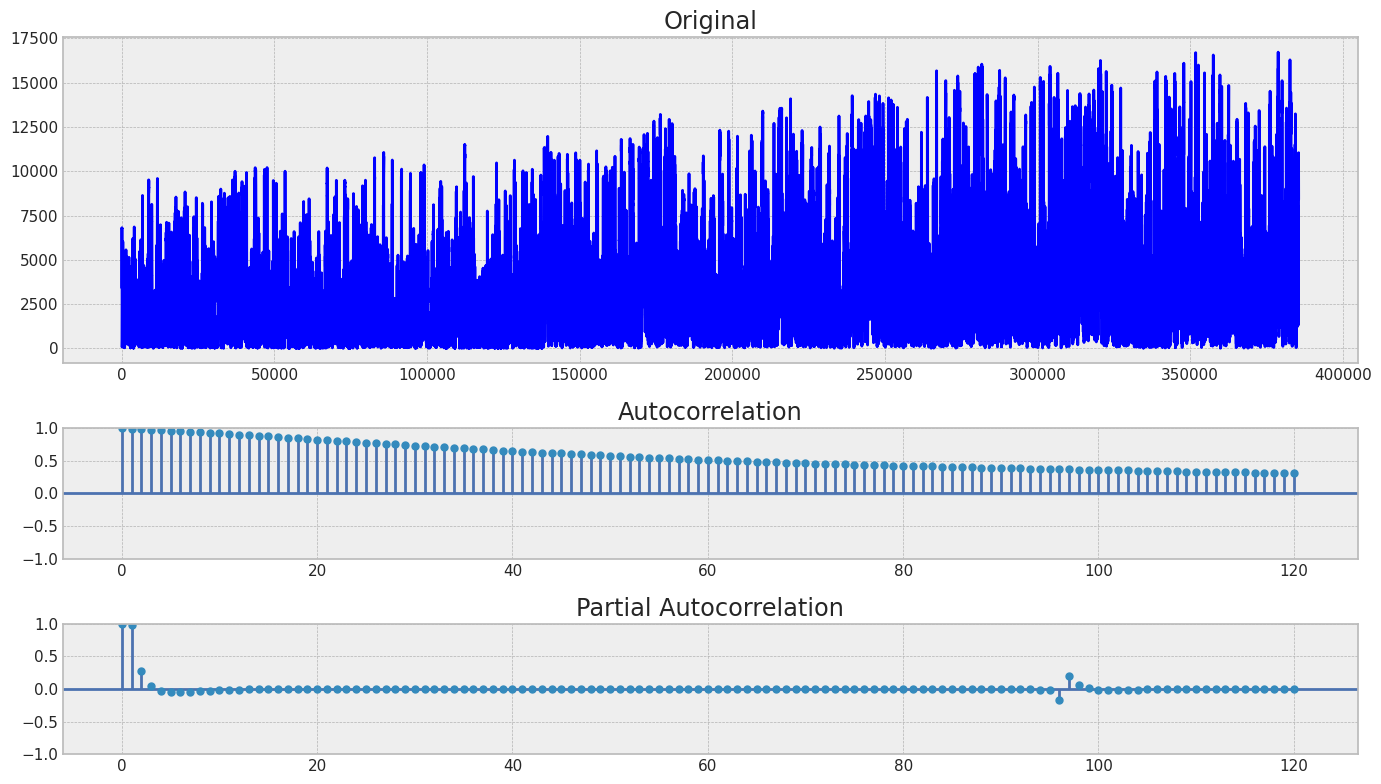

In [23]:
tsplot(df['y'],lags=24*5)

In [15]:
print(is_normal(shapiro(df['y'])))
print(is_normal(kstest_normal(df['y'])))

Not Normal
Not Normal


<Axes: xlabel='y', ylabel='Count'>

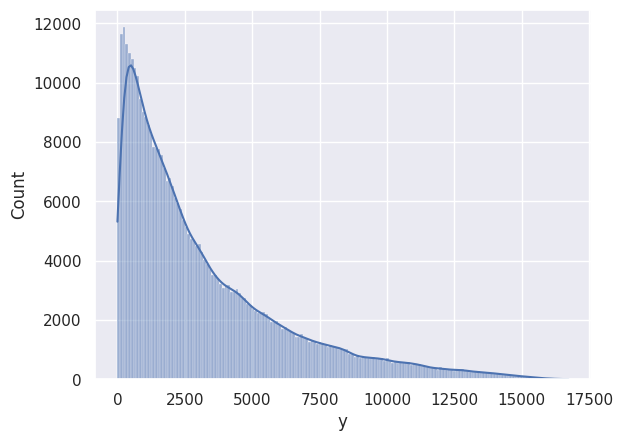

In [16]:
sns.histplot(df,x='y',kde=True)

In [17]:
df.isnull().sum()

ds    0
y     0
dtype: int64

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

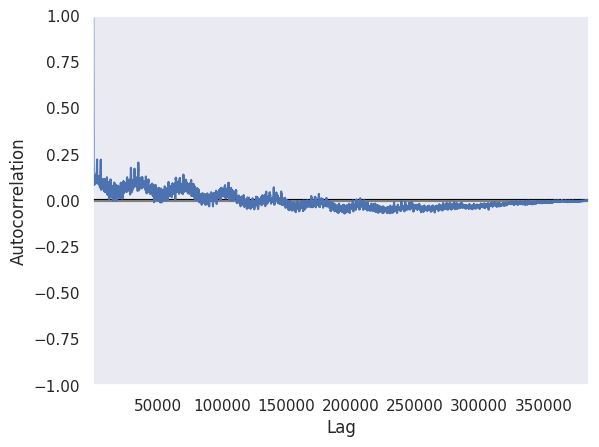

In [43]:
autocorrelation_plot(df['y'])

In [44]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
ds,385566,2016-07-01 04:21:04.513468672,2011-01-01 00:00:00,2013-10-01 02:48:45,2016-07-01 04:37:30,2019-04-01 06:56:15,2021-12-30 07:45:00,NaN
y,385566.0,3183.560481,0.0,905.0,2164.0,4529.8775,16727.5,3045.941591


In [24]:
df['weekday'] = df['ds'].dt.day_name()
df['month'] = df['ds'].dt.month_name()
df['year'] = df['ds'].dt.year.astype('string')
df['hour'] = df['ds'].dt.strftime('%H').astype('string')

In [25]:
df

,ds,y,weekday,month,year,hour
0,2011-01-01 00:00:00,3416.00,Saturday,January,2011,00
1,2011-01-01 00:15:00,4755.00,Saturday,January,2011,00
2,2011-01-01 00:30:00,4939.00,Saturday,January,2011,00
3,2011-01-01 00:45:00,4939.00,Saturday,January,2011,00
4,2011-01-01 01:00:00,4998.00,Saturday,January,2011,01
...,...,...,...,...,...,...
385561,2021-12-30 06:45:00,8140.31,Thursday,December,2021,06
385562,2021-12-30 07:00:00,8162.33,Thursday,December,2021,07
385563,2021-12-30 07:15:00,8405.11,Thursday,December,2021,07
385564,2021-12-30 07:30:00,8503.48,Thursday,December,2021,07


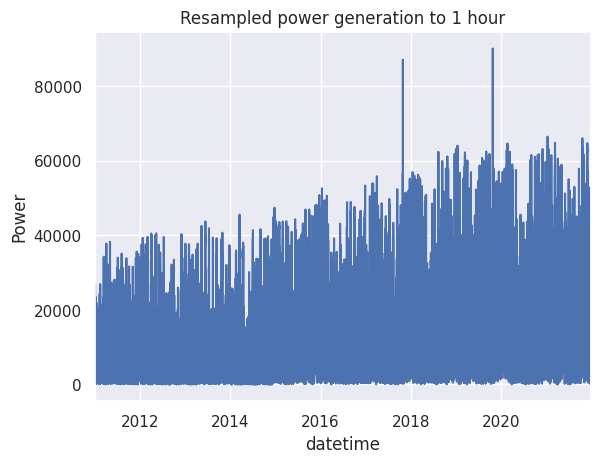

In [39]:
group_df = (df.set_index('ds')).resample('H')['y'].sum()
group_df.plot(kind='line')
plt.xlabel('datetime')
plt.ylabel('Power')
plt.title('Resampled power generation to 1 hour')
plt.show()

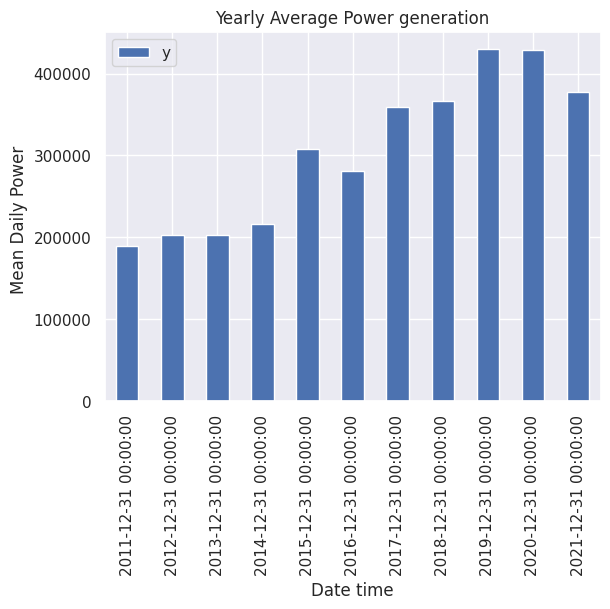

In [30]:
year_df = pd.DataFrame(df.set_index('ds').resample('1D')['y'].sum()).resample('1Y').mean()
year_df.plot.bar()
plt.title("Yearly Average Power generation")
plt.xlabel("Date time")
plt.ylabel("Mean Daily Power ")
plt.show()

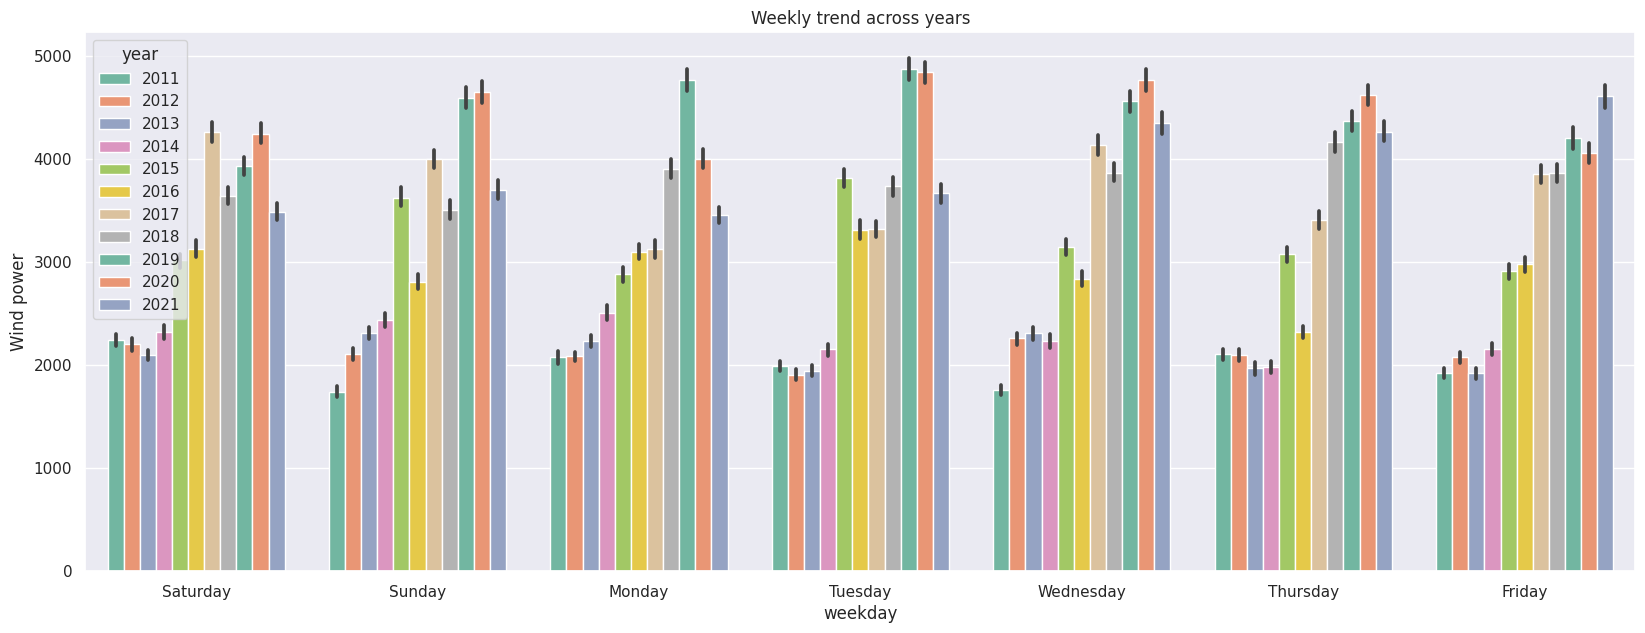

In [33]:
fig,axes = plt.subplots(1,1,figsize=(20,7))
sns.barplot(data = df,x='weekday',y='y',hue='year',palette='Set2',ax=axes)
plt.ylabel('Wind power')
plt.title('Weekly trend across years')
plt.show()

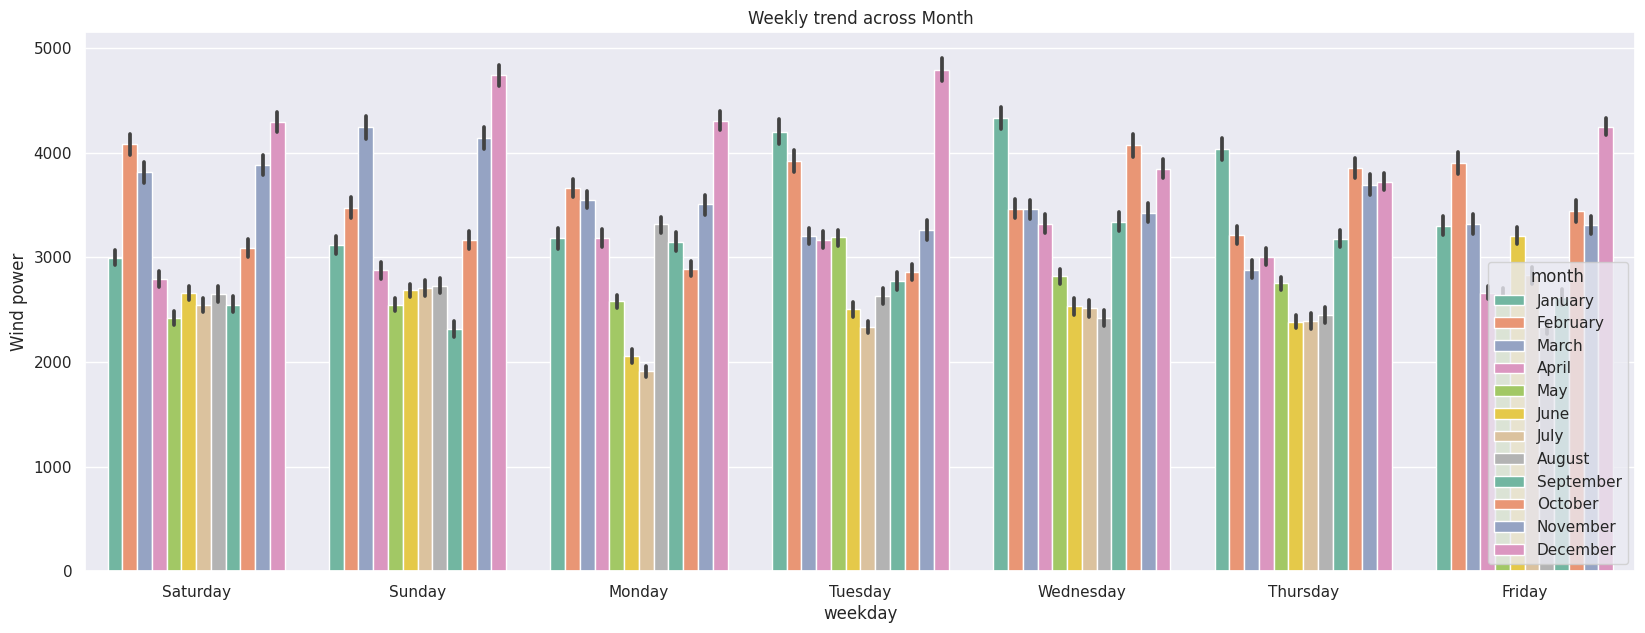

In [35]:
fig,axes = plt.subplots(1,1,figsize=(20,7))
sns.barplot(data = df,x='weekday',y='y',hue='month',palette='Set2',ax=axes)
plt.ylabel('Wind power')
plt.title('Weekly trend across Month')
plt.show()

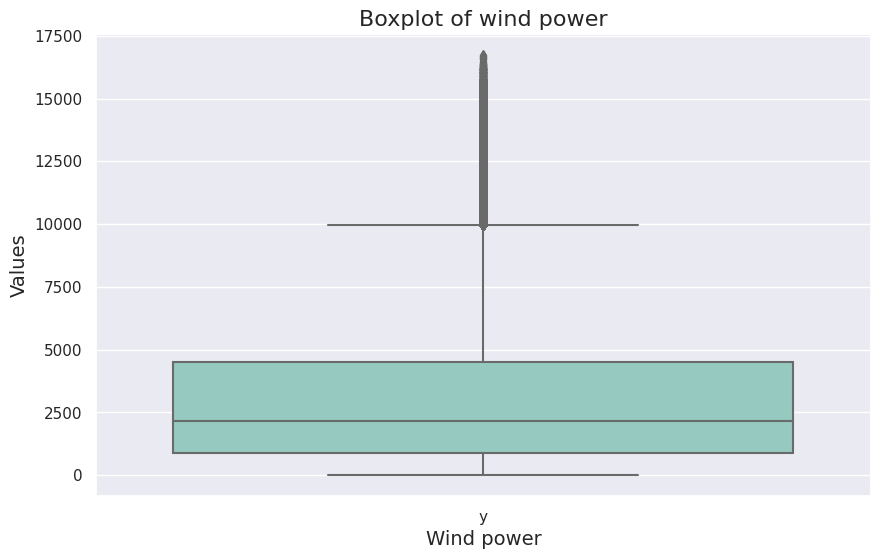

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, palette="Set3")    
plt.title("Boxplot of wind power", fontsize=16)
plt.xlabel("Wind power", fontsize=14)
plt.ylabel("Values", fontsize=14) 
plt.show()

## Make stationarity

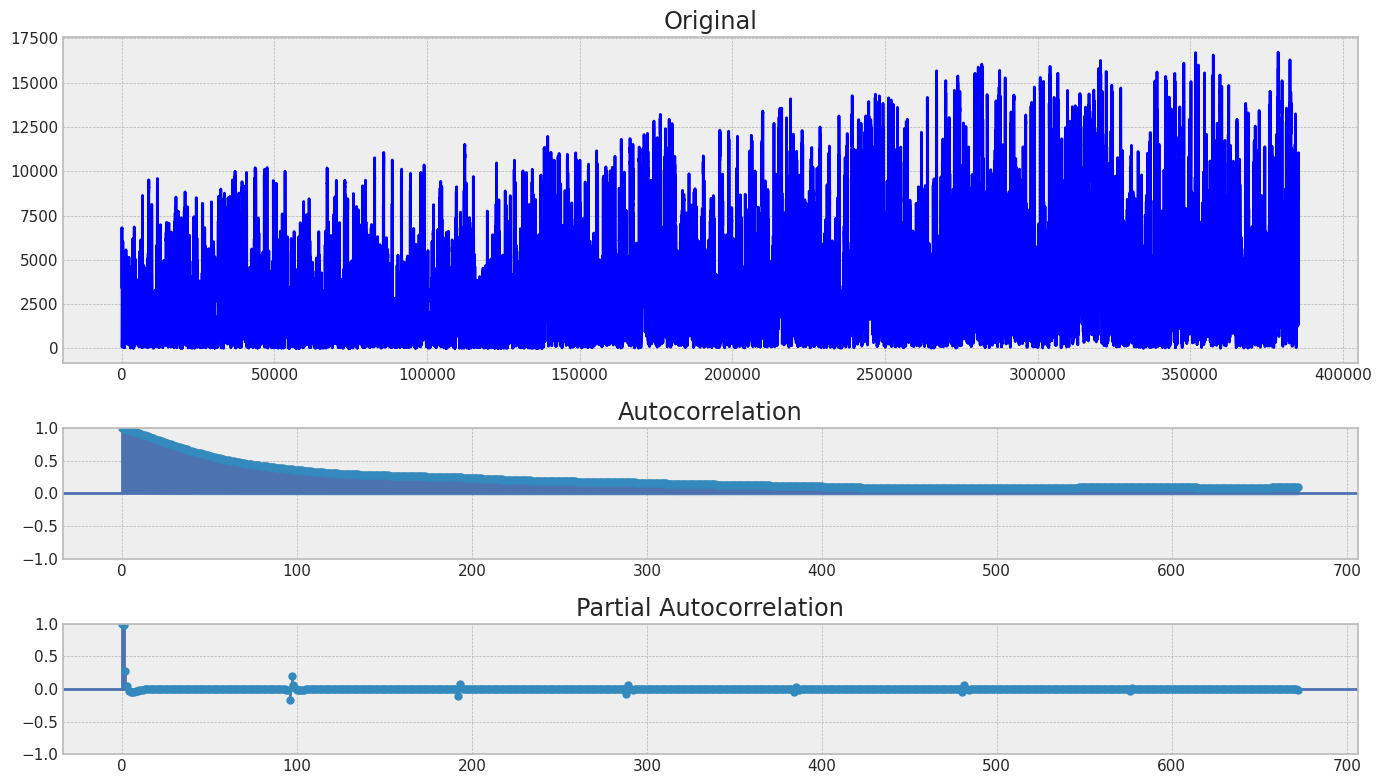

In [46]:
tsplot(df['y'],lags=96*7) #96 - 1day *7 - week

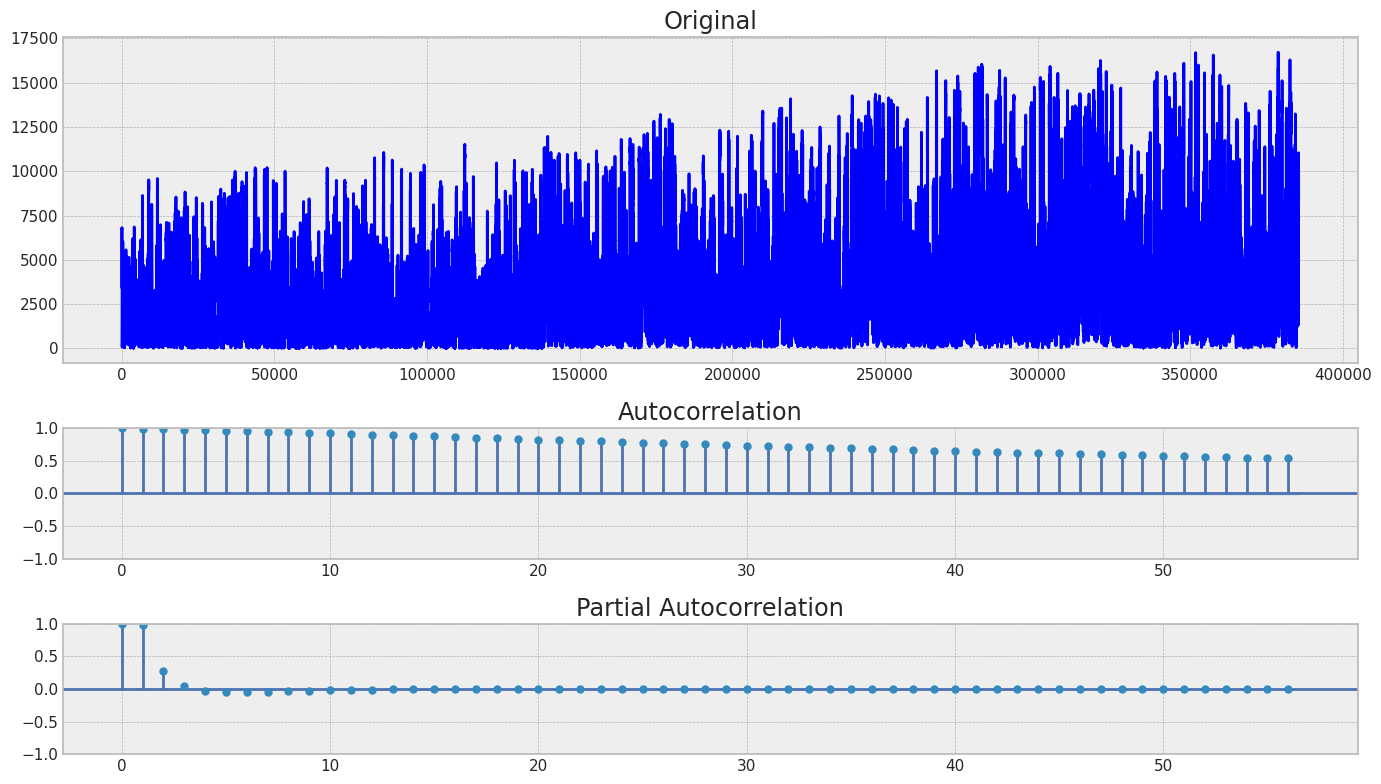

In [47]:
df['Power_boxcox'] = boxcox(df['y'], 1)
tsplot(df['Power_boxcox'])


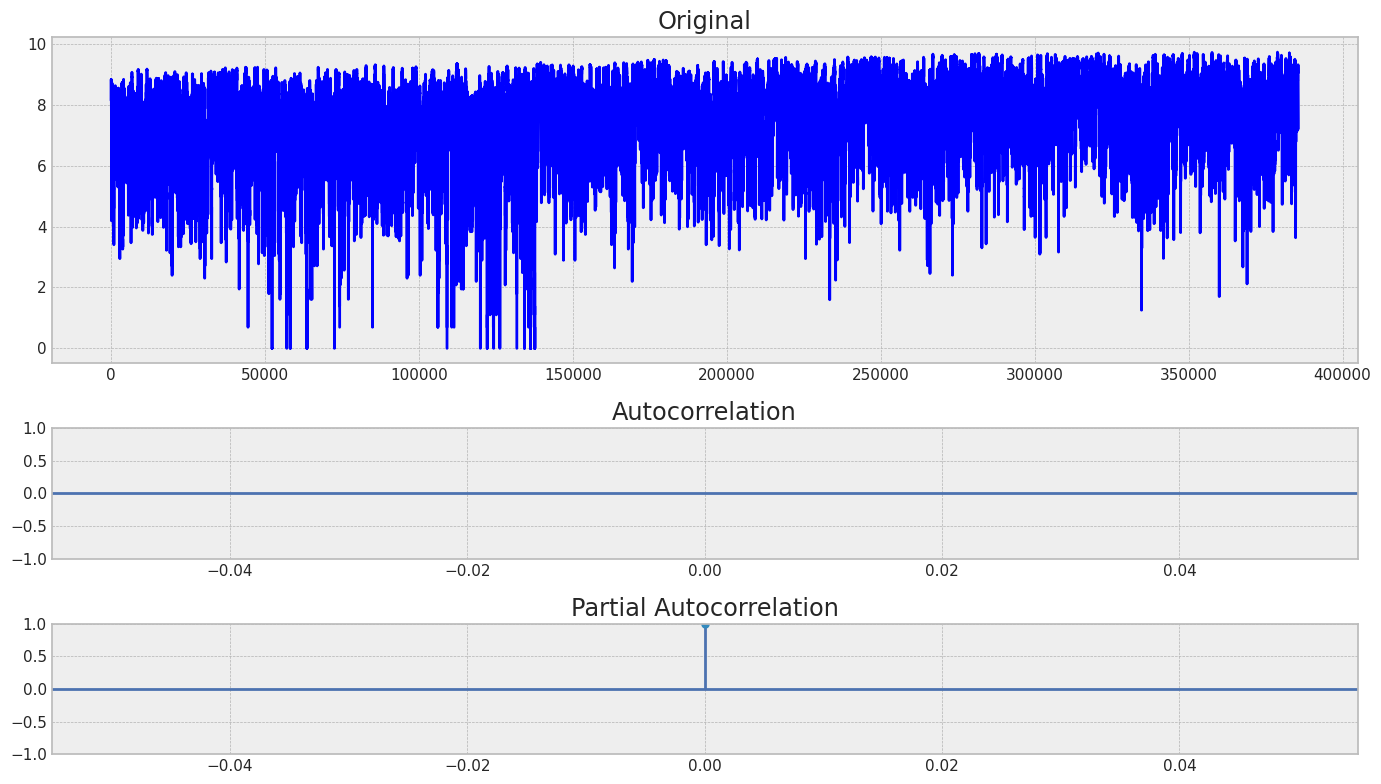

In [50]:
df['Power_log']= np.log(df['y'])
tsplot(df['Power_log'],lags=96*7)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

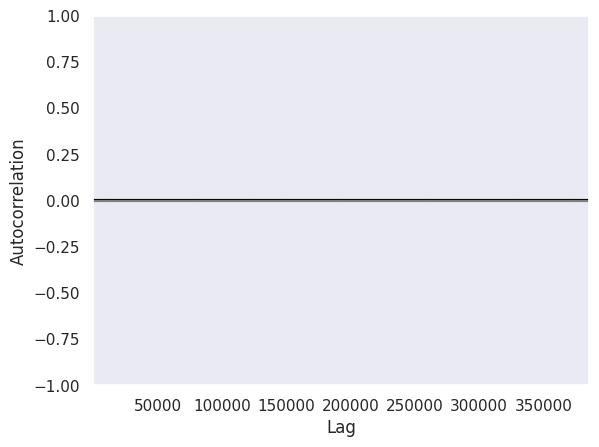

In [54]:
autocorrelation_plot(df['Power_log'])

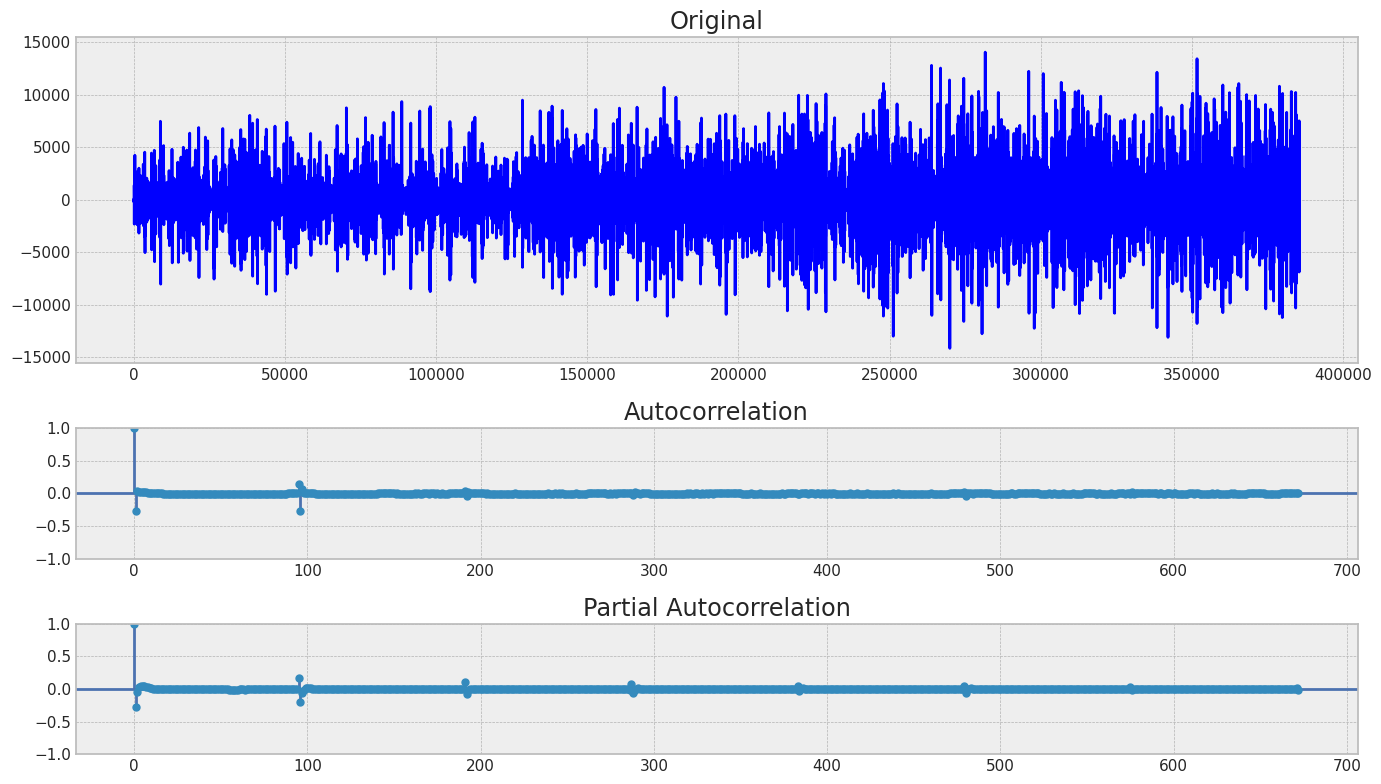

In [52]:
Power_diff= np.diff(df['y'])
tsplot(Power_diff,lags=96*7)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

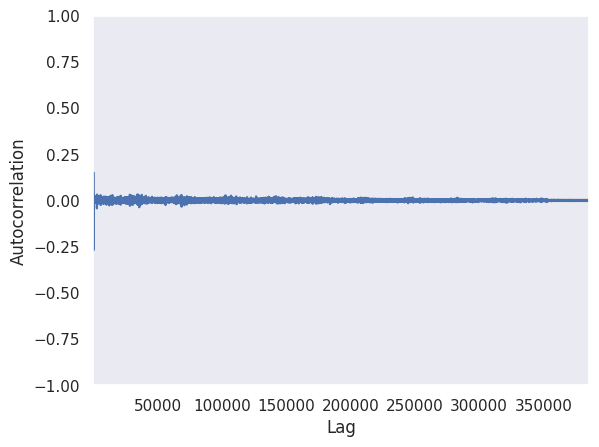

In [53]:
autocorrelation_plot(Power_diff)

# Analysis Conclusion in Markdown for Jupyter Notebook

## Power Generation Analysis

The analysis of the power generation time series data reveals several key insights:

### Yearly Trends:
- The years 2017 and 2019 exhibit significant spikes in power generation per hour.
- The overall power generation is highest in the years 2019 and 2020.

### Weekly Trends:
- The overall sum of power generated on Tuesday, Thursday, Friday, and Saturday was high in the year 2021.
- The overall sum of power generated on Monday and Sunday was high in the year 2019.

### Monthly Trends:
- The highest power generation occurs in December, February, and January.

### Outliers:
- The boxplot indicates a substantial number of outliers in the power generation data.

### Seasonality and Trends:
- Autocorrelation plots suggest the presence of cyclic patterns and an overall increasing trend over the years.

### Transformation and Stationarity:
- The Box-Cox transformation did not yield significant results.
- Differencing the time series by the first order led to improved stationarity.

**Overall, the analysis suggests that wind power generation exhibits seasonality, with the most energy produced during certain months. Additionally, the presence of outliers and non-stationarity in the original series necessitated transformation, and differencing proved effective in achieving stationarity.**



# Building model

In [91]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculates the mean absolute percentage error (MAPE) between true and predicted values.

    Parameters:
    - y_true (array-like): Array or Pandas Series of true values.
    - y_pred (array-like): Array or Pandas Series of predicted values.

    Returns:
    - mape (float): Mean absolute percentage error.

    Example Usage:

    # Assuming 'true_values' and 'predicted_values' are arrays or Pandas Series
    mape_value = mean_absolute_percentage_error(true_values, predicted_values)
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [95]:
def is_weekend(ds):
    """
    Checks if a given date is a weekend day (Saturday or Sunday).

    Parameters:
    - ds (str or Timestamp): Date in string or Timestamp format.

    Returns:
    - is_weekend (bool): True if the date is a weekend day, False otherwise.

    Example Usage:

    # Assuming 'date_string' is a string representation of a date
    is_weekend_flag = is_weekend(date_string)
    """
    date = pd.to_datetime(ds)
    return (date.dayofweek == 5 or date.dayofweek == 6)


In [99]:
def df_formatting(df):
    """
    Formats a DataFrame containing time series data by aggregating it at the hourly level, adding weekend and weekday flags.

    Parameters:
    - df (DataFrame): Input DataFrame with columns 'ds' (datetime) and 'y' (target variable).

    Returns:
    - formatted_df (DataFrame): Formatted DataFrame with columns 'ds' (datetime), 'y' (target variable), 'weekend', and 'weekday'.

    Example Usage:

    # Assuming 'raw_data' is a DataFrame with 'ds' and 'y' columns
    formatted_data = df_formatting(raw_data)
    """
    df_hour = (df.set_index('ds')).resample('H')['y'].sum() 
    df = df_hour.reset_index()
    df.columns  = ['ds','y']
    df['weekend'] = df['ds'].apply(is_weekend)
    df['weekday'] = ~df['ds'].apply(is_weekend)
    return df

In [146]:
def train_prophet(df,ntest = False):
    """
    Trains a Prophet time series forecasting model on the provided DataFrame.

    Parameters:
    - df (DataFrame): Formatted DataFrame with columns 'ds' (datetime) and 'y' (target variable).
    - ntest (int or False, optional): Number of test data points to exclude from training. Defaults to False.

    Returns:
    - prophet_model (Prophet): Trained Prophet model.

    Example Usage:

    # Assuming 'formatted_data' is a DataFrame formatted with df_formatting function
    trained_prophet_model = train_prophet(formatted_data, ntest=20)
    """
    if not ntest:
        train_df = df
    else:
        train_df = df[:-ntest]
        
    prophet = Prophet(seasonality_mode='additive',
                      yearly_seasonality=False,
                      daily_seasonality=False,
                      weekly_seasonality=6,
                      seasonality_prior_scale=0.01)
    prophet.add_seasonality(name='hourly',
                      # an hour is 0.04167 days
                      period=1 / 24,
                      # experiment with this value
                      fourier_order=5)
    prophet.add_seasonality(name='daily_weekend',
                          period=1,
                          fourier_order=3,
                          condition_name='weekend')
    
    prophet.add_seasonality(name='daily_weekday',
                          period=1,
                          fourier_order=3,
                          condition_name='weekday')
    prophet.add_country_holidays('DE')
    prophet.fit(train_df)

    return prophet

In [114]:
def prophet_forecasting(df, model ,ntest = False, period = 30):
    """
    Generates forecasts using a trained Prophet model and evaluates performance if test data is provided.

    Parameters:
    - df (DataFrame): Formatted DataFrame with columns 'ds' (datetime) and 'y' (target variable).
    - model (Prophet): Trained Prophet model.
    - ntest (int or False, optional): Number of test data points to evaluate model performance. Defaults to False.
    - period (int, optional): Number of days to forecast into the future. Defaults to 30.

    Returns:
    - forecast (pd.DataFrame): DataFrame containing the forecasted values.

    Example Usage:

    # Assuming 'formatted_data' is a DataFrame formatted with df_formatting function
    # and 'trained_prophet_model' is a Prophet model trained with train_prophet function
    forecast_data = prophet_forecasting(formatted_data, trained_prophet_model, ntest=20, period=30)
    """

    future_price = model.make_future_dataframe(periods=period,freq='H')
    future_price['weekend'] = future_price['ds'].apply(is_weekend)
    future_price['weekday'] = ~future_price['ds'].apply(is_weekend)
    forecast = model.predict(future_price)
    
    if ntest:
        test_df = df[:-ntest]
        error = mean_absolute_percentage_error(
            df[len(test_df):len(test_df)+ntest]['y'], 
            forecast[len(test_df):len(test_df)+ntest]['yhat'])
        print("Mean absolute percentage error {0:.2f}%".format(error))
    
    fig = model.plot(forecast)

    fig2 = model.plot_components(forecast)
    
    return forecast

In [115]:
df_form = df_formatting(df)

In [116]:
df_form

,ds,y,weekend,weekday
0,2011-01-01 00:00:00,18049.00,True,False
1,2011-01-01 01:00:00,20961.00,True,False
2,2011-01-01 02:00:00,22521.00,True,False
3,2011-01-01 03:00:00,24071.00,True,False
4,2011-01-01 04:00:00,25428.00,True,False
...,...,...,...,...
96387,2021-12-30 03:00:00,25099.92,False,True
96388,2021-12-30 04:00:00,27460.06,False,True
96389,2021-12-30 05:00:00,31316.13,False,True
96390,2021-12-30 06:00:00,33687.68,False,True


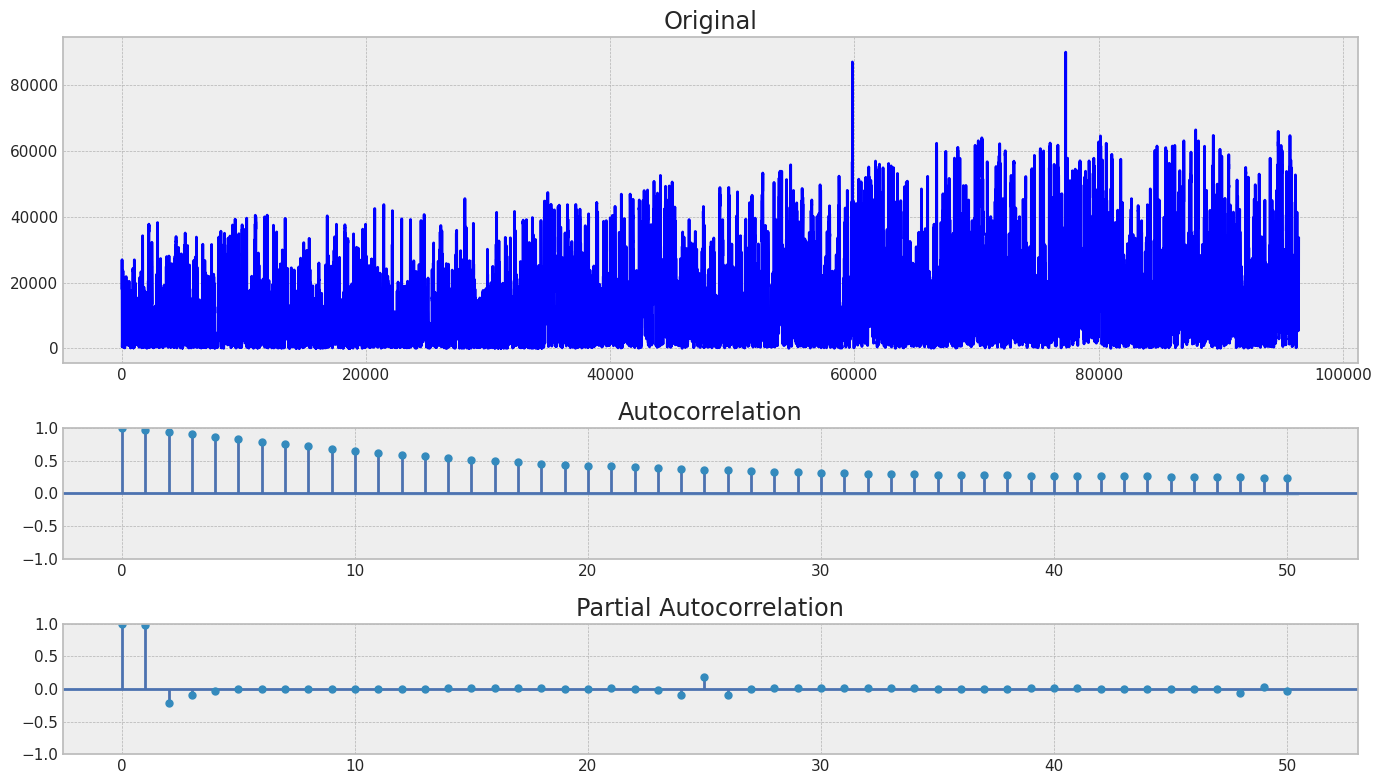

In [110]:
tsplot(df_form['y'])

In [148]:
model = train_prophet(df_form,ntest=24*30)

11:34:48 - cmdstanpy - INFO - Chain [1] start processing
11:36:11 - cmdstanpy - INFO - Chain [1] done processing


Mean absolute percentage error 210.51%


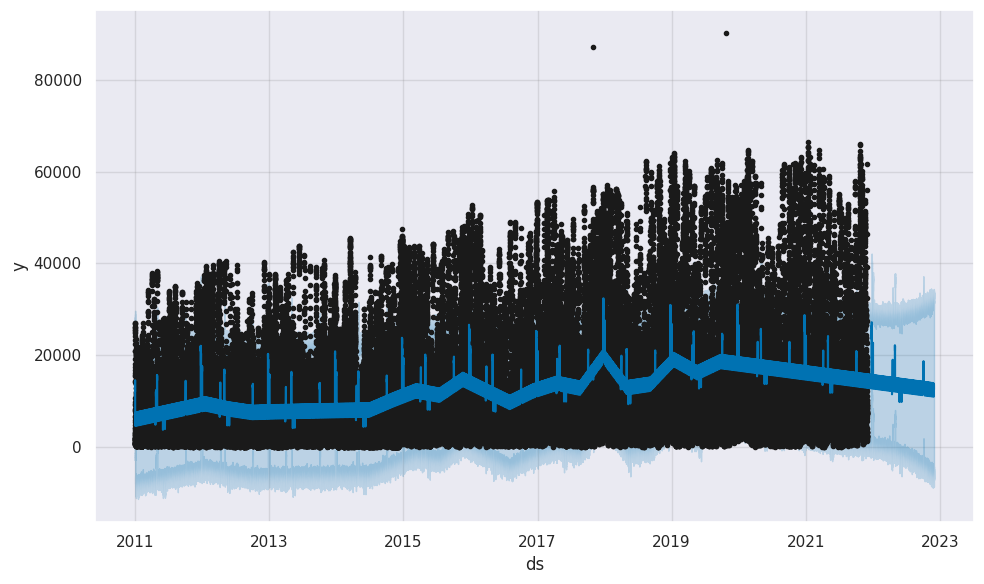

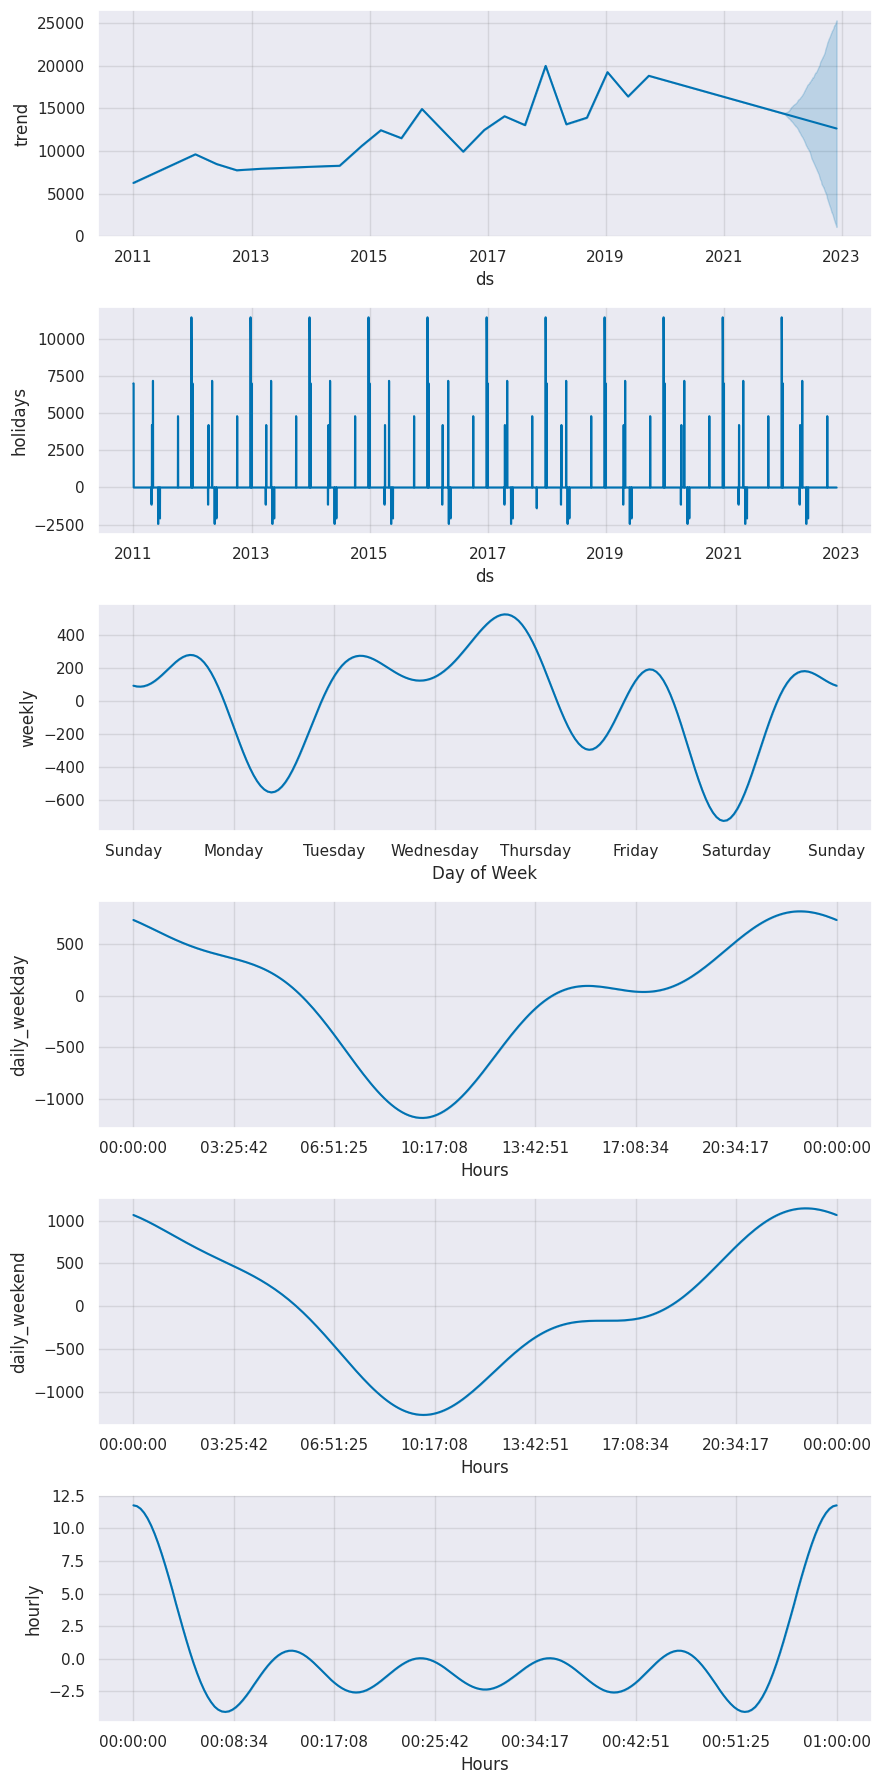

In [149]:
forecast  = prophet_forecasting(df_form,model,ntest=24*30,period=24*365)

# future year forecasting

In [150]:
model = train_prophet(df_form)

11:53:04 - cmdstanpy - INFO - Chain [1] start processing
11:54:40 - cmdstanpy - INFO - Chain [1] done processing


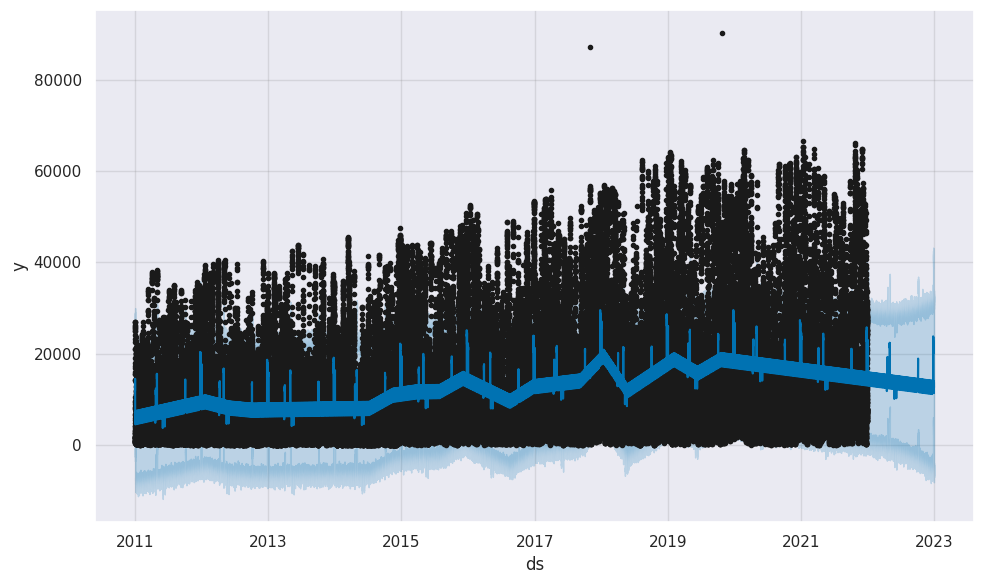

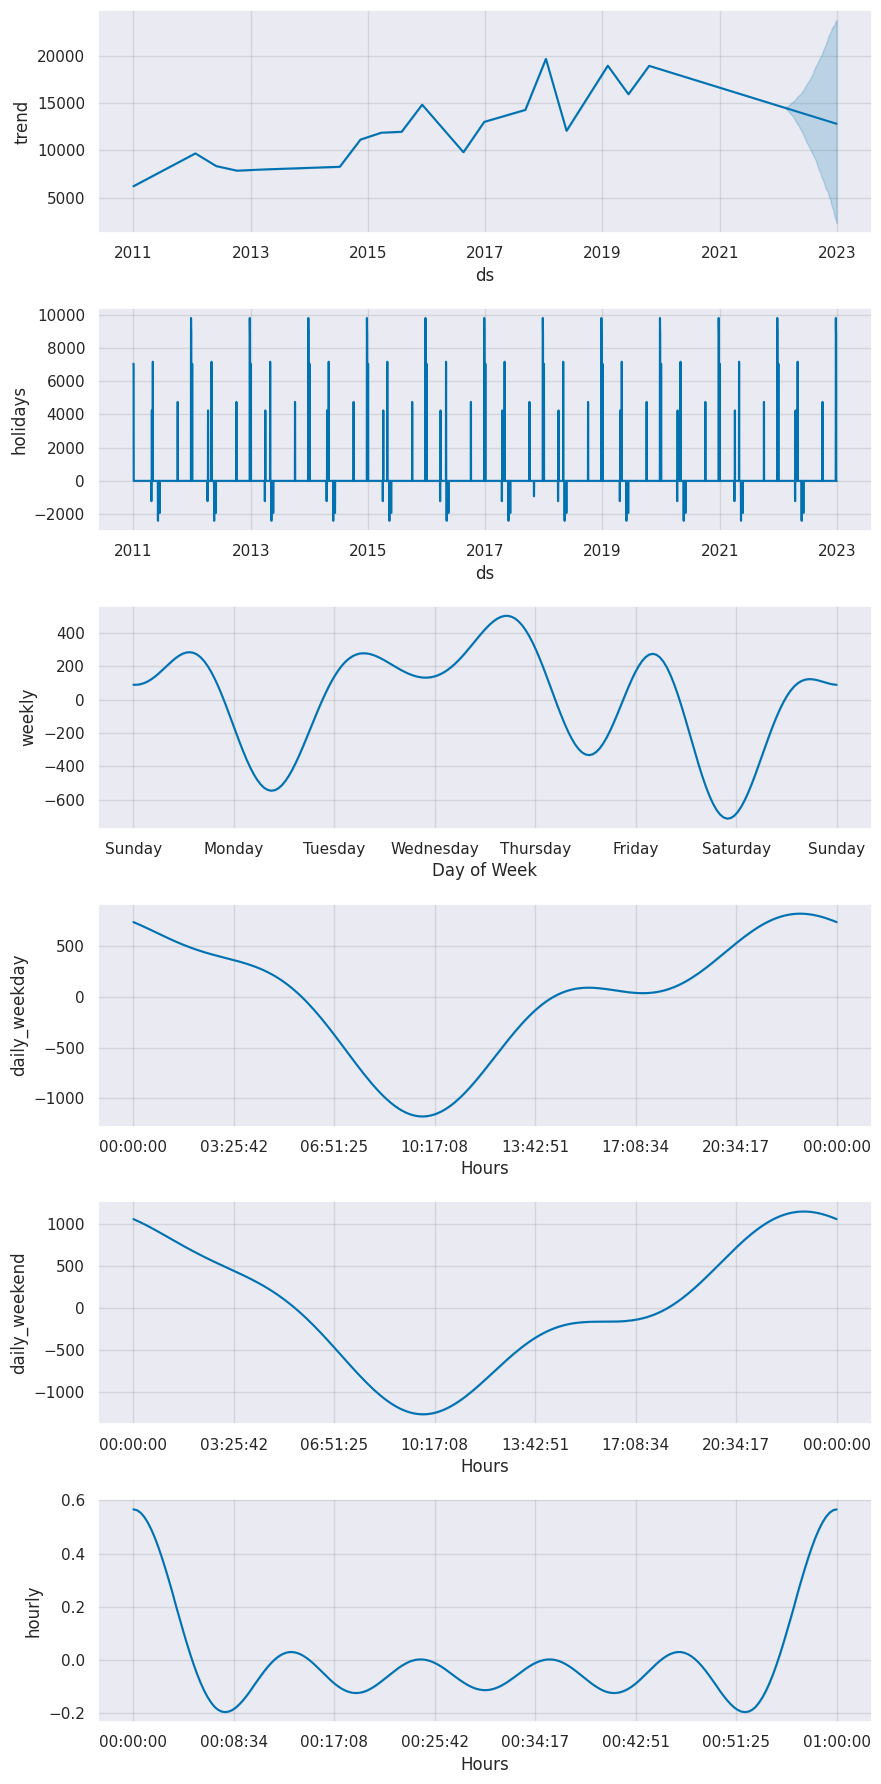

In [151]:
forecast  = prophet_forecasting(df_form,model,ntest=False,period=24*365)

# Prophet Model Evaluation and Conclusion

## Model Overview

The Prophet model was chosen for time series forecasting, leveraging its strengths in capturing seasonality and handling holidays. Here are the key components and customization in the model:

- **Seasonality Components:**
  - **Hourly Seasonality:** Captures the daily fluctuations with a Fourier order of 5.
  - **Weekly Seasonality:** Incorporates a weekly seasonality with a Fourier order of 3, distinguishing between weekends and weekdays.
  - **Country Holidays:** Accounts for holidays in Germany (DE).

- **Training and Forecasting:**
  - The model was trained on the formatted dataset, excluding the last 30 days as a test set.
  - A forecast was generated for the next 365 days (1 year).

## Model Performance

- **Mean Absolute Percentage Error (MAPE):** The MAPE for the test set (last 30 days) is calculated as 210.51%. This indicates a relatively high percentage error between the actual and predicted values.

## Model Visualization

- **Forecast Plot:** The model's forecast for the next year is visualized, showing the predicted values along with uncertainty intervals.

![Prophet Forecast Plot](data/output.png)

- **Component Plots:** The model's decomposition into trend, weekly seasonality, and holidays is visualized, providing insights into the underlying patterns.

![Prophet Component Plots](data/trend.png)

## Conclusion

While Prophet is a robust model for many time series forecasting tasks, its performance on this dataset appears suboptimal. The high MAPE suggests that the model may not be effectively capturing the complex patterns and variations in the wind power generation data. Possible reasons for this could include:

1. **Complex Patterns:** The data may contain intricate patterns or dependencies that are not well captured by Prophet's default seasonality components.

2. **Outliers:** The presence of outliers, as seen in the boxplot analysis, might be affecting the model's ability to generalize.

3. **Model Hyperparameters:** The chosen hyperparameters and seasonality components may not be the most suitable for this specific dataset.

Further exploration and experimentation with alternative models or fine-tuning of Prophet's parameters may be necessary to improve forecasting accuracy.
